# Analysis Exp. 2 - Visual search endpoints

In [1]:
import os, sys

# Local modules
sys.path.append('./..')
import data_processing
import visualization
import stats

# Data management
import pandas as pd 
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib.patches import Patch


# Suppress pandas future-warning about categorical dtypes
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


### Calculate localization errors and search durations

#### Load experimental data

In [3]:
## Note: this analysis script loads all data at once into memory. In case of limited
## resources, consider adjusting the script for an iterative approach (e.g. looping over subjects).

# Specify which data to load
data_dir = data_processing.DATA_DIR_EXP2
subjects = data_processing.SUBJECTS_EXP2 # or specify subset of subjects
practice_trials = data_processing.PRACTICE_TRIALS_EXP2
data_keys = ['TrialConfigRecord', 'EngineDataRecord'] # which type of data to load
experimental_tasks = ['VisualSearch']

# Get Filenames
exp_filenames, clbr_filenames = data_processing.get_filenames(data_dir = data_dir,
                                                              subjects= subjects, 
                                                              data_keys = data_keys) 

# Load raw data 
exp_data = data_processing.load_data_from_filenames(exp_filenames)

# Load the locations of the visual targets
targets = data_processing.get_target_locations()

In [4]:
# Process into useful format
data_processing.reformat_data(exp_data,
                              expand_columns= ['XRHeadPos', 'XROriginPos', 'HandRPos',
                                              'PointLocationHand', 'PointLocationHead','PointLocationEye',])


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [22:41<00:00, 680.77s/it]


In [5]:
# Timeseries data of the unity game engine: head position, gaze raycasts, button events, etc.
eng_data = data_processing.drop_invalid(exp_data['EngineDataRecord'],
                        exclude_trials = practice_trials,
                        include_tasks = experimental_tasks,
                        clip_valid_frames = True,
                        include_subjects = subjects)

# Config. data saved after each trial: exp. conditions, trial duration, no. of events, etc. (One row for each trial) 
trc_data = data_processing.drop_invalid(exp_data['TrialConfigRecord'],
                                        exclude_trials = practice_trials,
                                        include_tasks = experimental_tasks,
                                        include_subjects = subjects).set_index('TrialIdentifier')

## Data Analysis

In [33]:
if not os.path.exists('./out'):
    os.makedirs('./out')

#### Calculate search durations and localization errors for each search instance

In [7]:
def calc_search_durations(data):
    """Add search duration and the reported events (i.e. button presses)
    to the columns. Returns dataframe with only the event-frames.
    Note: this function performs inplace operations on input dataframe.""" 

    # Useful grouping indices
    trial_index= ['TrialIdentifier',]
    targ_index = ['TrialIdentifier','ReportedEventsCount'] # To group by visual search instance (within a trial)
    time_index = ['TrialIdentifier', 'TimeStamp'] # To index by timestamp (unique frame identifier)

    # Total reported events (i.e. total number of button presses)
    total_reported = data.groupby(trial_index).ReportedEventsCount.max() # n_presses per trial
    data['TotalReportedEvents'] = total_reported.loc[data.TrialIdentifier].values # Add col. to dataframe 
    data['ReportedAsFound'] = data.ReportedEventsCount < data.TotalReportedEvents # All targets but the last one are marked as found

    # Find and calculate the time between 'event triggers' reported by subject.
    # (This is the search duration for each search instance). 
    start_trial = data.ne(data.shift()).TrialIdentifier # True for first frame of each trial
    event_occurred = data.groupby(trial_index).ReportedEventsCount.diff() > 0 # True for frames where event count increases (trigger was pressed)
    start_of_search = data.where(start_trial | event_occurred).TimeStamp.ffill()  # Timestamps for the start of search 
    start_of_search.loc[data.ReportedEventsCount > 0] += 1e7 # Next visual search instances starts 1 second after the previous one ended

    # Add the search durations and the elapsed time as cols to the dataframe. 
    data['SearchDuration'] = (data.TimeStamp - start_of_search) * 1e-7 # elapsed time for each search instance.
    data['SecondsSinceTrialStart'] =  (data.TimeStamp - data.where(start_trial).TimeStamp.ffill()) * 1e-7

    # From all frames, select the frames where trigger was pressed (event)
    # (An output dataframe is returned with only the event frames).
    end_of_trial = data.ne(data.shift(-1)).TrialIdentifier # True for last frame of each trial
    event_occurred = data.groupby('TrialIdentifier').ReportedEventsCount.diff() > 0
    event_frames = data.loc[event_occurred | end_of_trial].copy()
    
    # Some data (e.g. search duration) are found in the final frame before the event.
    # (These data are copied to the output dataframe)
    previous_frames = data.shift().loc[event_occurred | end_of_trial] # Mask of previous frames
    copy_from_previous = ['ReportedEventsCount', 'SearchDuration', 'ReportedAsFound'] # Which variables to copy
    event_frames[copy_from_previous] = previous_frames[copy_from_previous] # Copy to the output dataframe

    return event_frames
    
def angle_between(a, b):
    """Calculate the shortest angle between two complex numbers (represented as vectors on the complex plane)
    return value in degrees"""
    theta = np.angle(a) - np.angle(b)
    theta *= 180/np.pi  #convert to degrees
    theta = (theta + 180) % 360 - 180 # find the shortest angle (e.g. -270 -> 90 deg.)
    return theta

def calc_localization_errors(events, targets, columns=None):
    """For each search event, calculate the angles between the pointing vector (Unity raycast)
    and the true relative position vector. 
    Returns a dataframe with localization errors for head, hand and eyes (in degrees)."""

    # The output dataframe
    out = events.copy()

    ## First, all data are represented in complex numbers.
    # Positions of the sensors in world space
    out['OrgPosXZ'] = (out.XROriginPosX + out.XROriginPosZ * 1j).values
    out['HeadPosXZ'] = (out.XRHeadPosX + out.XRHeadPosZ*1j).values
    out['HandPosXZ'] = (out.HandRPosX + out.HandRPosZ*1j).values

    # Position of the targets in world space
    out['TrgPosXZ'] = (targets.loc[out['ActiveTarget']].PosX + \
                       targets.loc[out['ActiveTarget']].PosZ * 1j).values

    # Pointing locations (world space)
    out['HandPntXZ'] = (out.PointLocationHandX + out.PointLocationHandZ*1j).values
    out['HeadPntXZ'] = (out.PointLocationHeadX + out.PointLocationHeadZ*1j).values
    out['EyePntXZ'] = (out.PointLocationEyeX + out.PointLocationEyeZ*1j).values

    ## Then, the pointing vectors are calculated as difference between the pointing 
    ## locations (i.e. where the Unity raycast from the hand/head/eye 'hits' 
    ## the world) and the sensor locations.
    # Raycasts from hand
    out['Hand2HandPnt'] = out.HandPntXZ - out.HandPosXZ # Raycast hit location (hand) w.r.t. hand pos
    out['Head2HandPnt'] = out.HandPntXZ - out.HeadPosXZ # Raycast hit location (hand) w.r.t. head pos
    
    # Raycasts from head and eyes
    out['Head2HeadPnt'] = out.HeadPntXZ - out.HeadPosXZ # Raycast hit location (head) w.r.t. head pos
    out['Head2EyePnt'] =  out.EyePntXZ - out.HeadPosXZ # Raycast hit location (eyes) w.r.t. head pos
    
    # Target position vectors relative to the hand/head
    out['Hand2Targ'] = out.TrgPosXZ - out.HandPosXZ # Target location w.r.t. hand pos
    out['Head2Targ'] = out.TrgPosXZ - out.HeadPosXZ # Target location w.r.t. head pos

    ## Lastly, the localization errors are calculated by computing the angle between
    ## the pointing vector and the true relative position vector.
    # Localization errors (angles with respect to vector from head to target)
    out['LocalizationErrorHand'] = angle_between(out.Head2HandPnt, out.Head2Targ)
    out['LocalizationErrorHead'] = angle_between(out.Head2HeadPnt, out.Head2Targ)
    out['LocalizationErrorEyes'] = angle_between(out.Head2EyePnt, out.Head2Targ)
    out['AbsLocalizationErrorHand'] = out.LocalizationErrorHand.abs()
    out['AbsLocalizationErrorHead'] = out.LocalizationErrorHead.abs()
    out['AbsLocalizationErrorEyes'] =  out.LocalizationErrorEyes.abs()

    ## For additional analyses the differences between localization errors are 
    ## also calculated, but these are not used in the main analysis.
    # Relative errors (mismatch)
    out['HeadHandMismatch'] = (out.LocalizationErrorHead - out.LocalizationErrorHand  + 180) % 360 - 180
    out['EyeHandMismatch'] = (out.LocalizationErrorEyes - out.LocalizationErrorHand  + 180) % 360 - 180
    out['HeadEyeMismatch'] = (out.LocalizationErrorHead - out.LocalizationErrorEyes + 180) % 360 - 180

    # Only keep the relevant columns, remove the rest. 
    if columns is None:
        columns = ['ActiveTarget','Subject', 'Block', 'RelativeTrialNumber', 
                   'ExperimentalTask', 'GazeCondition','TotalReportedEvents', 
                   'ReportedSubjectiveRating', 'ReportedAsFound', 'HeadPosXZ', 
                   'HandPosXZ', 'OrgPosXZ', 'TrgPosXZ', 'HandPntXZ', 'HeadPntXZ',
                   'EyePntXZ',  'Hand2HandPnt', 'Head2HandPnt','Head2HeadPnt',
                   'Head2EyePnt', 'Hand2Targ', 'Head2Targ', 
                   'SearchDuration', 'LocalizationErrorHand',
                   'LocalizationErrorHead','LocalizationErrorEyes',
                   'AbsLocalizationErrorHand', 'AbsLocalizationErrorHead',
                   'AbsLocalizationErrorEyes', 'HeadHandMismatch', 'EyeHandMismatch',
                   'HeadEyeMismatch','TimeStamp', 'SecondsSinceTrialStart']

    return out.set_index(['TrialIdentifier','ReportedEventsCount'])[columns]

# Subjective rating was missing. Adding it manually.
eng_data['ReportedSubjectiveRating'] = trc_data.loc[eng_data.TrialIdentifier,'ReportedSubjectiveRating'].values

# Calculate the search durations of the completed searches
event_frames = calc_search_durations(eng_data)

# Calculate the localization errors
localization_errors = calc_localization_errors(event_frames, targets=targets)

#### Exclude invalid searches

These are somewhat arbitrary cutoff values. Changing the values does not lead to different conclusions.
Some rationales behind the values:
- A localization error > 15 degrees would mean that the target object is literally not in the phosphene simulation.
- Looking at the overall performance, an accuracy less than 0.6 can be interpreted as exceptionally bad performance (more than 2 standard deviations below the average across subjects).
- If less than 3 target objects are found, the averages for each condition are based on low numbers and therefore can show higher variability. 

In [8]:
# Cutoff values
MAX_LOCALIZATION_ERROR = 15 # maximal degrees of deviation to count as a correctly found target
MINIMAL_ACCURACY = 0.6 # subjects with lower overall-accuracy will be excluded
MINIMAL_TARGETS = 3 # subjects who have found less targets in all of the conditions are excluded

## First, it is identified which search events resulted in a 'correctly found' target. This is
## based on the absolute localization error. Note: for the head-steered conditions, the head-pointing
## error is used, while for the gaze-steered conditions, it is the eye-pointing error

# Which pointing reference to use:
reference = {'GazeAssistedSampling': 'AbsLocalizationErrorEyes',
             'GazeIgnored': 'AbsLocalizationErrorHead',
             'SimulationFixedToGaze': 'AbsLocalizationErrorHead'}

# Extract the localization errors and mark the correctly found targets
localization_errors['WhichReference'] = localization_errors.GazeCondition.replace(reference)
localization_errors['ReferenceError'] = localization_errors.apply(lambda x: x[x.WhichReference], axis=1)
localization_errors['FoundCorrectTarget'] = localization_errors['ReferenceError'] < MAX_LOCALIZATION_ERROR

## Secondly, bad-performing subjects and difficult targets are also excluded. 
## The remaining searches are the 'succesfull search events'

# Create a mask to store the validity/success of each search instance
mask = pd.DataFrame(index=localization_errors.index, dtype=bool)

# Exclude unfinished searches 
mask['ReportedAsFound'] = localization_errors.ReportedAsFound.astype(bool)
completed_searches = localization_errors.loc[mask.ReportedAsFound]

# Exclude bad-performing subjects
accuracy_per_subject = completed_searches.groupby('Subject').FoundCorrectTarget.mean()
n_targets_per_cond = completed_searches.groupby(['Subject','GazeCondition']).ActiveTarget.count().unstack(fill_value=0)
too_few_targets = n_targets_per_cond.loc[(n_targets_per_cond < MINIMAL_TARGETS).any(axis=1)].index
too_low_pointing_acc = accuracy_per_subject.loc[accuracy_per_subject < MINIMAL_ACCURACY].index
exclude_subjects = too_few_targets.union(too_low_pointing_acc)
mask['ValidSubject'] = ~localization_errors.Subject.isin(exclude_subjects)

# Exclude difficult targets
accuracy_per_target = completed_searches.groupby('ActiveTarget').FoundCorrectTarget.mean()
exclude_targets = accuracy_per_target.loc[accuracy_per_target < MINIMAL_ACCURACY].index
mask['ValidTarget'] = ~localization_errors.ActiveTarget.isin(exclude_targets)

# Get the valid searches
valid_mask = mask.ValidSubject & mask.ValidTarget
valid_searches = localization_errors.loc[valid_mask]

# Get the succesful (correct) searches
mask['FoundCorrectTarget'] = localization_errors.FoundCorrectTarget.astype(bool)
succesful_mask = mask.ReportedAsFound & mask.ValidSubject & mask.ValidTarget & mask.FoundCorrectTarget
successful_searches =  localization_errors.loc[succesful_mask]

## Save and print the results

# Write excluded targets and subjects
log_min_targets = f'{[s for s in too_few_targets]} (did not find at least {MINIMAL_TARGETS} targets in each condition)'
log_min_accuracy = f'{[s for s in too_low_pointing_acc]} (did not find the correct target in at least {MINIMAL_ACCURACY} of the cases)'
log_difficult_targets = f'{[t for t in exclude_targets]} (not found at least {MINIMAL_ACCURACY} of the cases)'
log = 'These subjects and targets were excluded from the analysis:\n' + '\n'.join([log_min_targets,log_min_accuracy,log_difficult_targets])
with open('out/excluded.txt', 'w') as f:
    f.write(log)
print(log)

# Save data to tsv files    
localization_errors.to_csv('out/all_searches.tsv', sep='\t', index=True)    
completed_searches.to_csv('out/completed_searches.tsv', sep='\t', index=True)
valid_searches.to_csv('out/valid_completed_searches.tsv', sep='\t', index=True)
successful_searches.to_csv('out/successful_valid_completed_searches.tsv', sep='\t', index=True)
mask.to_csv('out/inclusion_mask.tsv', sep='\t', index=True)

These subjects and targets were excluded from the analysis:
['S37', 'S39'] (did not find at least 3 targets in each condition)
['S38', 'S51'] (did not find the correct target in at least 0.6 of the cases)
['Shoes_3'] (not found at least 0.6 of the cases)


In [9]:
## Print some additional stats..
n_total = len(mask)
n_found = int(mask[['ReportedAsFound']].sum())
n_valid = mask[['ReportedAsFound', 'ValidSubject', 'ValidTarget']].all(axis=1).sum()
n_succesful_total = mask[['ReportedAsFound','FoundCorrectTarget']].all(axis=1).sum()
n_succesful_valid = mask[['ReportedAsFound', 'ValidSubject', 'ValidTarget','FoundCorrectTarget']].all(axis=1).sum()

print(f'out of {n_total} searches, {n_found} were reported as found.\n' +
#       f'out of {n_found} reported targets, {n_succesful_total} target reports were correct.' +
      f'out of {n_found} reported targets, {n_found-n_valid} target reports were excluded (bad subjects/targets)\n' +
      f'out of the remaining {n_valid} reported targets, {n_succesful_valid} were identifying the correct target.') 
     
total_counts = successful_searches.groupby(['Subject', 'GazeCondition'])['SearchDuration'].count()
trial_counts = successful_searches.groupby(['Subject', 'TrialIdentifier', 'GazeCondition'])['SearchDuration'].count()
print(f'On average, the subjects succesfully found {total_counts.mean():.1f} targets in each condition ({trial_counts.mean():.1f} per trial)')
# print(trial_counts.unstack().mean())

out of 938 searches, 770 were reported as found.
out of 770 reported targets, 140 target reports were excluded (bad subjects/targets)
out of the remaining 630 reported targets, 582 were identifying the correct target.
On average, the subjects succesfully found 12.9 targets in each condition (4.8 per trial)


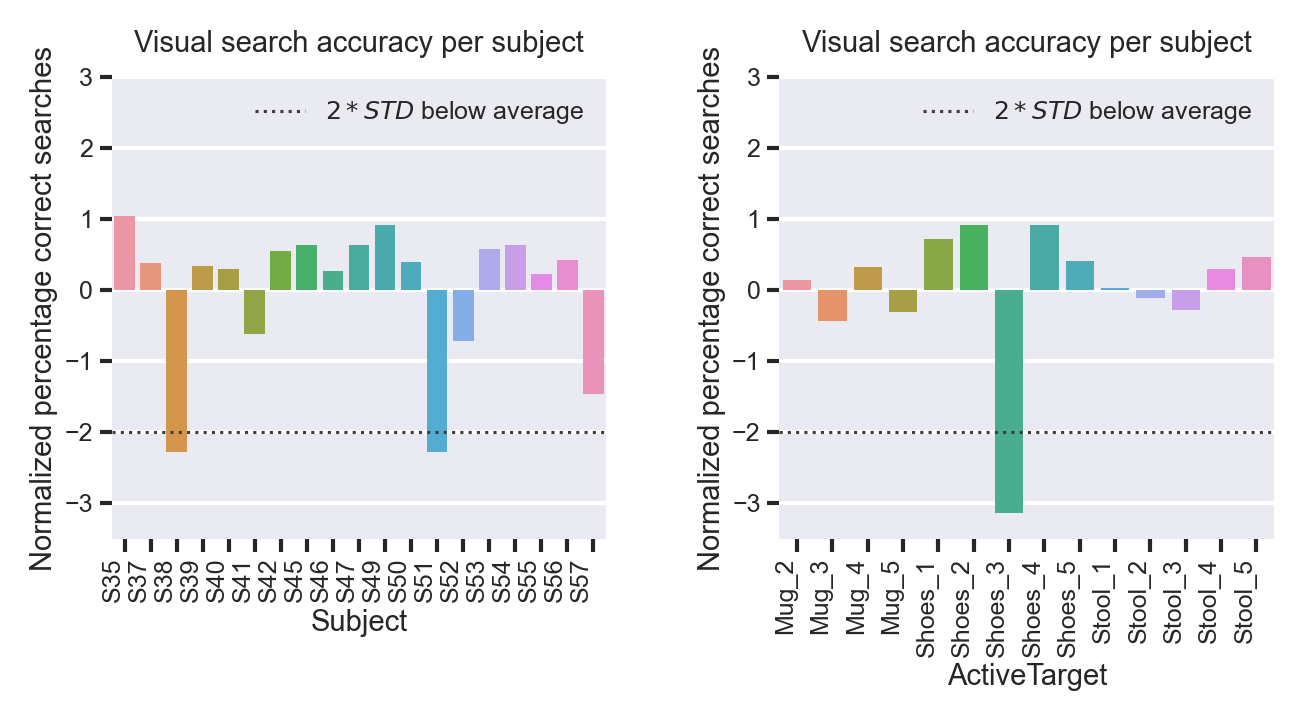

In [16]:
## Visualize the overall performance
fig,axs = visualization.create_subplots(2, figsize=(5,2))
visualization.set_figurestyle()
for i,group in enumerate(['Subject', 'ActiveTarget']):
    mean_perf = completed_searches.groupby(group)['FoundCorrectTarget'].mean()
    grand_mean = mean_perf.mean()
    grand_std = mean_perf.std()
    criterium = grand_mean - 2*grand_std

    dev_perf = (mean_perf-grand_mean) / grand_std

    dev_perf

    sns.barplot(data = dev_perf.reset_index(), x=group, y='FoundCorrectTarget', ax=axs[i])
    axs[i].set(ylabel='Normalized percentage correct searches', ylim=[-3.5,3], title='Visual search accuracy per subject')
    axs[i].set_xticks(axs[i].get_xticks(), axs[i].get_xticklabels(), rotation=90, ha='right')
    h = axs[i].axhline(-2, linestyle=':')
    axs[i].legend([h], ['$2*STD$ below average'])
plt.show()

# Statistical Analysis

#### Load the data

In [17]:
# # In case resuming the analysis from here, uncomment to load previously-saved intermediate results.

# localization_errors = pd.read_csv('out/all_searches.tsv', sep='\t').set_index(['TrialIdentifier','ReportedEventsCount']) 
# mask = pd.read_csv('out/inclusion_mask.tsv', sep='\t').set_index(['TrialIdentifier', 'ReportedEventsCount'])


# # Load the data used for plotting
# localization_errors = pd.read_csv('out/all_localization_errors.tsv', sep='\t').set_index(['TrialIdentifier','ReportedEventsCount'])
# valid_searches =  pd.read_csv('out/valid_localization_errors.tsv', sep='\t').set_index(['TrialIdentifier','ReportedEventsCount'])
# successful_searches =  valid_searches.loc[valid_searches.FoundCorrectTarget]

In [20]:
# Selection mask for the valid search instances
valid_mask = mask.ReportedAsFound & mask.ValidSubject & mask.ValidTarget
successful_mask = mask.ReportedAsFound & mask.ValidSubject & mask.ValidTarget & mask.FoundCorrectTarget
valid_searches = localization_errors.loc[valid_mask]
successful_searches = localization_errors.loc[successful_mask]

#### Mark invalid data with NaNs 

In [21]:
vs_data = localization_errors.copy()
vs_data.loc[~successful_mask, 'SearchDuration'] = np.nan

#### Average over subjects

In [22]:
endpoints = ['SearchDuration','ReportedSubjectiveRating']
group= 'Subject'

# By default, all search instances are only averaged per condition per subject. It is 
# possible to average them per trial as well, but this reduces the number of data-points. 
average_per_trial_first = False

# Average all search data for each trial
indep_vars = ['Subject', 'GazeCondition', 'Block', 'RelativeTrialNumber', 'ExperimentalTask', 'TotalReportedEvents']
vs_trial_data = vs_data.groupby(indep_vars+['TrialIdentifier'])[endpoints].mean().reset_index(indep_vars)

# Average over subjects 
data = vs_trial_data if average_per_trial_first else vs_data
avg = stats.average(data,y=endpoints,group=group)

#### Statistical tests

In [25]:
# Normality test
normality = stats.normality_test(avg, endpoints=endpoints)
non_normal_endpoints = [y for y in endpoints if normality.loc['AnyNonNormal', y]]
normal_endpoints = [y for y in endpoints if not normality.loc['AnyNonNormal', y]]
display('Normality test:',  stats.style(normality))

# Non-parametric tests
results_wilcoxon = pd.DataFrame()
if non_normal_endpoints:
    results_wilcoxon = stats.paired_test(avg, group='Subject', endpoints=non_normal_endpoints, test='Wilcoxon')
    # display('Results Wilcoxon:', stats.style(results_wilcoxon, alpha=0.05/3)) # Alpha corrected for multiple comparisons

# Parametric tests
results_t_test = pd.DataFrame()
if normal_endpoints:
    results_t_test = stats.paired_test(avg, group='Subject', endpoints=normal_endpoints, test='t-test')
    # display('Results t-test:', stats.style(results_t_test, alpha=0.05/3))

# All Results
stat_results = pd.concat([results_wilcoxon, results_t_test], axis=1)[endpoints]
display('Statistical results (merged non-param. + param. tests):', stats.style(stat_results, alpha=0.05/3))

'Normality test:'

,SearchDuration,ReportedSubjectiveRating
GazeAssistedSampling,1.000000,0.159617
GazeIgnored,1.000000,0.025091
SimulationFixedToGaze,1.000000,0.763309
AnyNonNormal,False,True


C:\Users\Jaap\Anaconda3\envs\SPVGaze\Lib\site-packages\scipy\stats\_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


'Statistical results (merged non-param. + param. tests):'

,SearchDuration,ReportedSubjectiveRating
Comparison,,
Gaze Locked <> Gaze Contingent,0.000144,0.000095
Gaze Contingent <> Gaze Ignored,0.510437,0.001690
Gaze Locked <> Gaze Ignored,0.000080,0.000004


In [26]:
# Save results
vs_trial_data.to_csv('out/visual_search_trial_endpoints.tsv', sep='\t')
avg.to_csv('out/visual_search_averaged_endpoints.tsv', sep='\t')
normality.to_csv('out/visual_search_normality_test.tsv', sep='\t')
stat_results.to_csv('out/visual_search_paired_testing.tsv', sep='\t')

import dataframe_image as dfi
dfi.export(stat_results, 'out/stats_visual_search.png')

### Visualization

In [27]:
# # In case resuming the analysis from here, uncomment to load previously saved results.
# avg = pd.read_csv('out/visual_search_averaged_endpoints.tsv', sep='\t')
# normality = pd.read_csv('out/visual_search_normality_test.tsv', sep='\t')
# stat_results = pd.read_csv('out/visual_search_paired_testing.tsv', sep='\t').set_index('Comparison')

# Display main results in table format (mean and standard deviation)
display(avg.groupby('GazeCondition')[endpoints].mean())
display(avg.groupby('GazeCondition')[endpoints].std())

stars = stat_results.applymap(stats.count_significance_stars)
stars

,SearchDuration,ReportedSubjectiveRating
GazeCondition,,
GazeAssistedSampling,16.449166,4.325607
GazeIgnored,15.414638,5.362379
SimulationFixedToGaze,26.998049,3.103006


,SearchDuration,ReportedSubjectiveRating
GazeCondition,,
GazeAssistedSampling,6.298247,1.108958
GazeIgnored,5.361696,1.079676
SimulationFixedToGaze,9.302676,1.125874


,SearchDuration,ReportedSubjectiveRating
Comparison,,
Gaze Locked <> Gaze Contingent,***,***
Gaze Contingent <> Gaze Ignored,n.s.,**
Gaze Locked <> Gaze Ignored,***,***


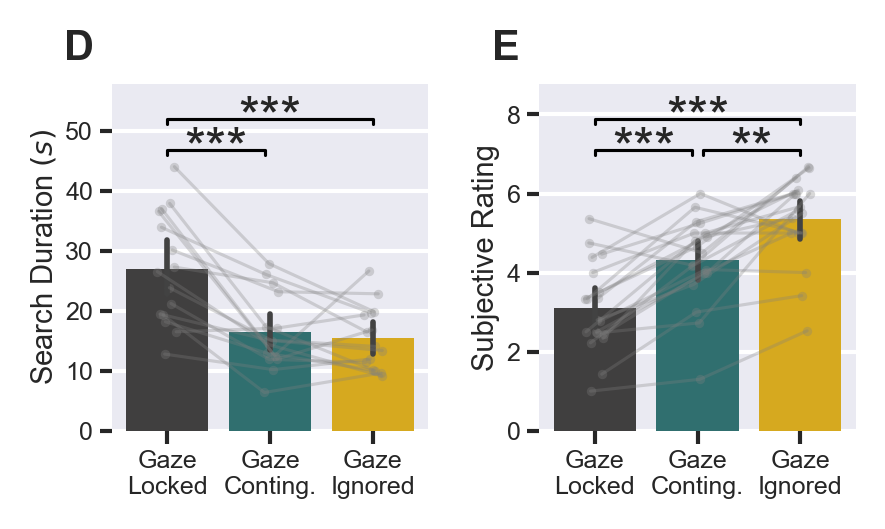

In [28]:
# Plotting parameters (titles, labels, etc.)
endpoints = ['SearchDuration','ReportedSubjectiveRating']
titles = ['', '']#['Search Duration',  'Subjective Rating']
y_lbls = ['Search Duration $(s)$', 'Subjective Rating',]

# Set the default figurestyle
visualization.set_figurestyle()

# Plot barplots and swarm plots overlay
fig,axs = visualization.create_subplots(2, figsize=(8*2/5,1.5))
fig,axs = visualization.bar_plots(avg, endpoints, axs=axs, fig=fig)
visualization.swarm_plots(avg, endpoints, group = 'Subject', axs=axs, fig=fig)
visualization.redefine_x_ticks(axs, remove_xlabel=True, new_line=True) # Clean (consistent) terminology and typography

# Apply figure parameters
for i, ax in enumerate(axs.flatten()):
    axs[i].set(title=titles[i],
               xticklabels = ['Gaze\nLocked', 'Gaze\nConting.', 'Gaze\nIgnored'],
               ylabel=y_lbls[i],)

    # Plot the significance lines
    visualization.add_significance_lines(axs[i], stars.replace({'n.s.': None}).iloc[:,i].values,
                               x_pairs=[(0,.95),(1.05,2.),(0,2.)],
                               rel_y=[0.81, 0.81, 0.9],)
# Add panel indices
visualization.add_panel_index(axs[0],'D')
visualization.add_panel_index(axs[1],'E')
plt.savefig('out/visual_search_endpoints.png', bbox_inches='tight')

### Training effects

(<Figure size 800x400 with 2 Axes>,
 array([<AxesSubplot: title={'center': 'SearchDuration'}, xlabel='Block', ylabel='SearchDuration'>,
        <AxesSubplot: title={'center': 'ReportedSubjectiveRating'}, xlabel='Block', ylabel='ReportedSubjectiveRating'>],
       dtype=object))

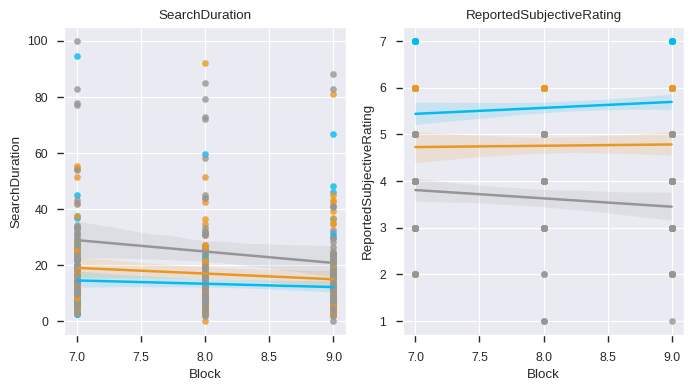

In [73]:
visualization.regression_plots(data=valid_searches.loc[valid_searches.Block>6], endpoints=['SearchDuration', 'ReportedSubjectiveRating'])

### Additional visualizations

#### All localization errors

In [31]:
# # Load data for plotting
# localization_errors = pd.read_csv('out/all_localization_errors.tsv', sep='\t').set_index(['TrialIdentifier','ReportedEventsCount'])
# valid_searches =  pd.read_csv('out/valid_localization_errors.tsv', sep='\t').set_index(['TrialIdentifier','ReportedEventsCount'])
# successful_searches =  valid_searches.loc[valid_searches.FoundCorrectTarget]

Text(0.5, 1.0, 'All_searches')

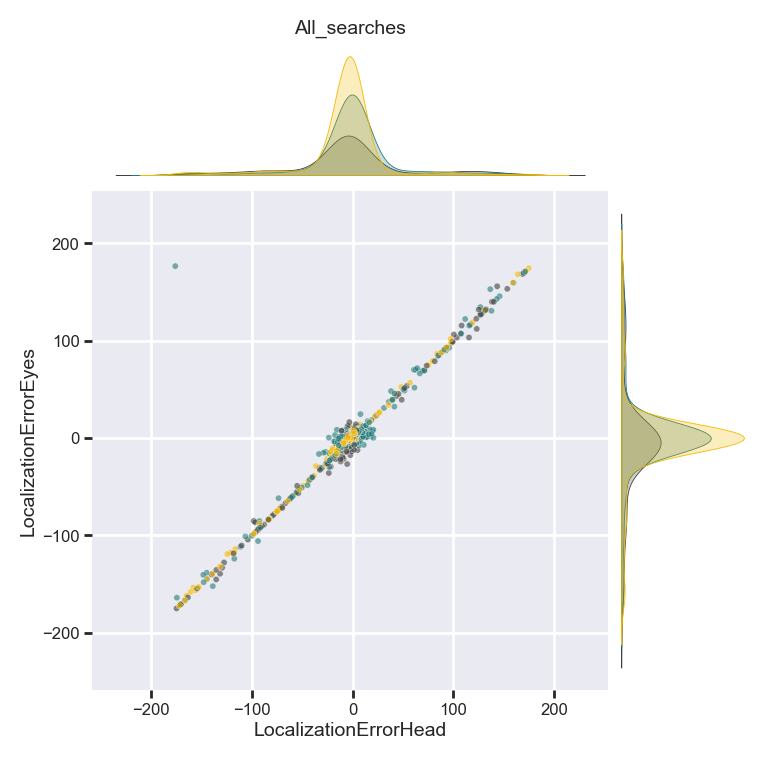

In [29]:
visualization.set_figurestyle()
handles = visualization.joint_distribution_plots(localization_errors, [('LocalizationErrorHead','LocalizationErrorEyes')])
handles[1].set_title('All_searches')

#### Difficult targets / bad subjects

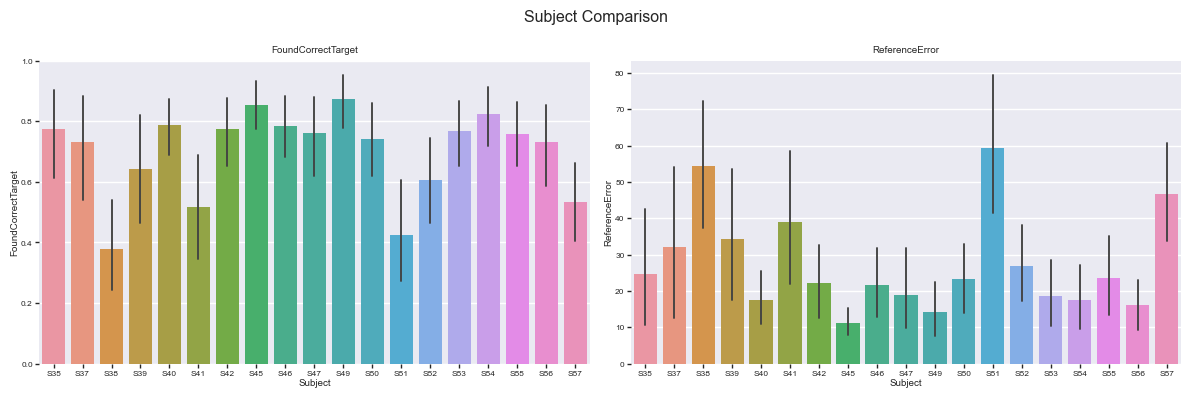

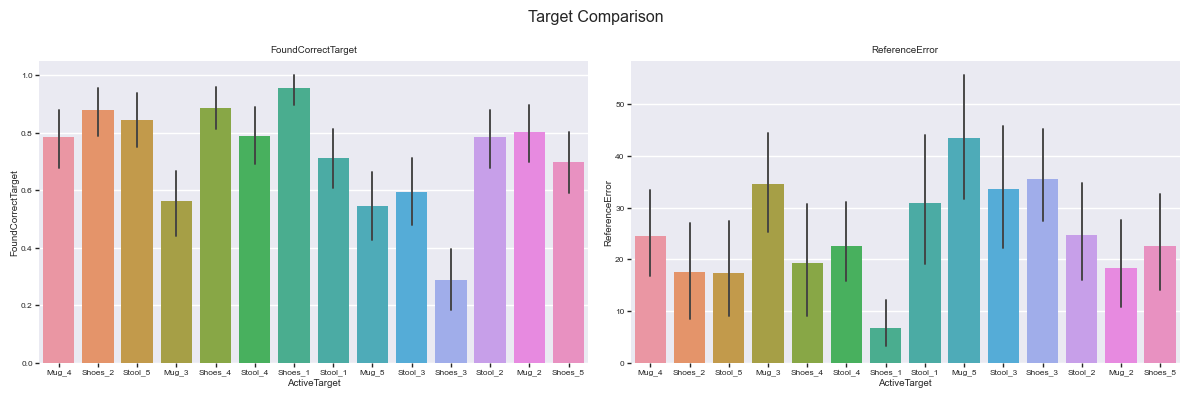

In [31]:
subjects = data_processing.SUBJECTS_EXP2
fig, axs = plt.subplots(1,2, figsize = (12,4))
visualization.bar_plots(localization_errors, x='Subject', endpoints=['FoundCorrectTarget', 'ReferenceError'], order=None,
                        fig=fig,axs=axs)
plt.suptitle('Subject Comparison')
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1,2, figsize = (12,4))
visualization.bar_plots(localization_errors, x='ActiveTarget', endpoints=['FoundCorrectTarget', 'ReferenceError'], order=None,
                       fig=fig,axs=axs)
plt.suptitle('Target Comparison')
plt.tight_layout()
plt.show()

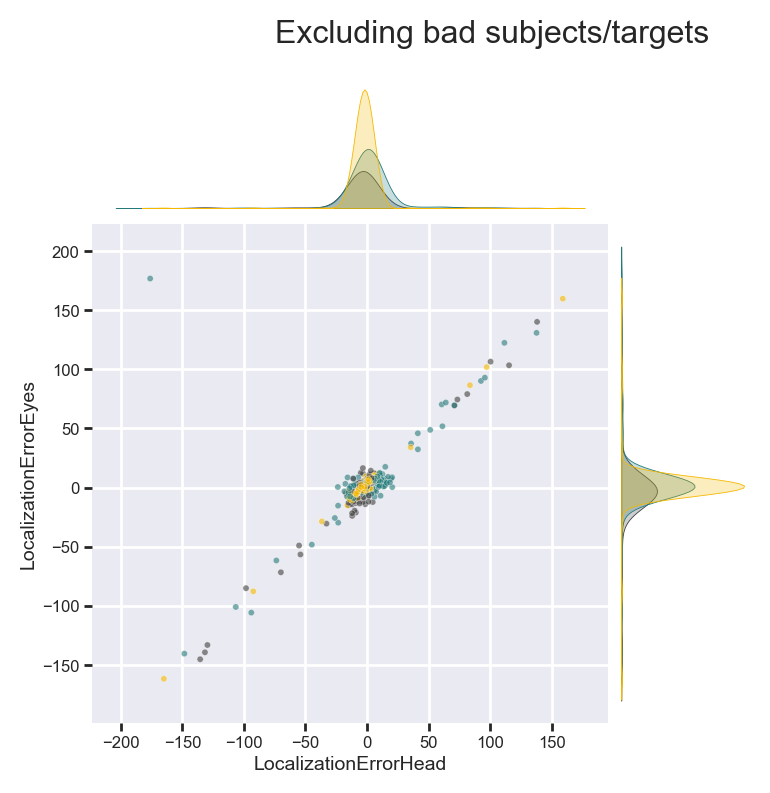

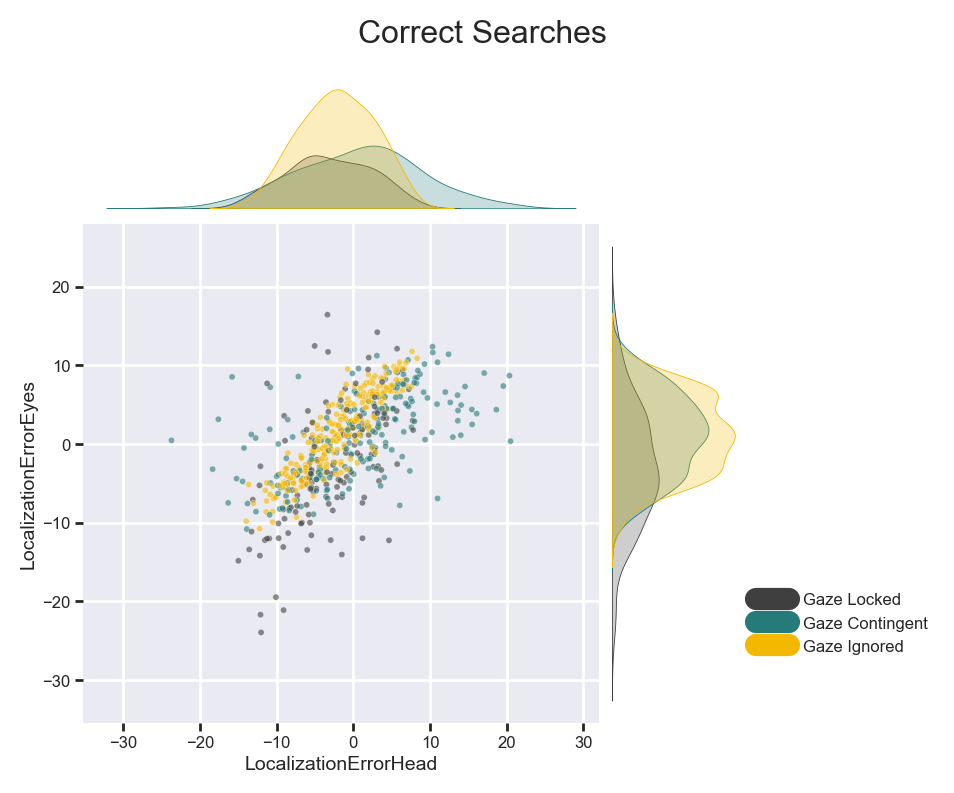

In [32]:
from visualization import COLORS, COND_REDEFINED
def add_legend(colors=COLORS.values(), labels=COND_REDEFINED.values(),ax=None, **kwargs):
    lines = [matplotlib.lines.Line2D([0], [0], color=c , lw=8) for c in colors]
    ax = plt.gca() if ax is None else ax
    ax.legend(lines, labels, **kwargs)


handles = visualization.joint_distribution_plots(valid_searches, [('LocalizationErrorHead','LocalizationErrorEyes')])
plt.suptitle('Excluding bad subjects/targets')
handles = visualization.joint_distribution_plots(successful_searches, [('LocalizationErrorHead','LocalizationErrorEyes')])
plt.suptitle('Correct Searches')


add_legend(loc='center left', bbox_to_anchor=(1, 0.2))
plt.show()